In [4]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

print(tf.__version__)
# https://www.tensorflow.org/tutorials/images/classification

2.12.0


In [ ]:
import shutil
src_path = r"/home/fish/programing/cancerClassifier/patch_images/"
dst_path = r"/home/fish/programing/cancerClassifier/splitData/"

# split the dataset 
# dont runn unless you wanna split the data again (you dont)
with open('data_labels_mainData.csv', 'r') as file:
    
    for line in file.readlines()[1:]:
        li = line.split(',')
        shutil.copyfile(src_path + str(li[2]), dst_path + str(li[3]) + '/' + str(li[2]))
        print(li)
        



In [123]:
batch_size = 32
img_height = 27
img_width = 27

train_ds = tf.keras.utils.image_dataset_from_directory(
  '/home/fish/programing/cancerClassifier/splitData/',
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
  '/home/fish/programing/cancerClassifier/splitData/',
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)


class_names = train_ds.class_names

Found 9896 files belonging to 4 classes.
Using 7917 files for training.
Found 9896 files belonging to 4 classes.
Using 1979 files for validation.


In [124]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)



In [125]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[10]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

print(len(image_batch))

0.16078432 1.0
32


2023-04-26 13:42:15.799745: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [7917]
	 [[{{node Placeholder/_0}}]]
2023-04-26 13:42:15.799989: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [7917]
	 [[{{node Placeholder/_0}}]]


In [141]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(256, activation='relu'),
  layers.Dense(num_classes)
])


In [142]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


In [143]:
model.summary()


Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_34 (Rescaling)    (None, 27, 27, 3)         0         
                                                                 
 conv2d_54 (Conv2D)          (None, 27, 27, 32)        896       
                                                                 
 max_pooling2d_54 (MaxPoolin  (None, 13, 13, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_55 (Conv2D)          (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_55 (MaxPoolin  (None, 6, 6, 64)         0         
 g2D)                                                            
                                                                 
 conv2d_56 (Conv2D)          (None, 6, 6, 128)       

In [144]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)


Epoch 1/10
248/248 [==============================] - 3s 10ms/step - loss: 0.9684 - accuracy: 0.5992 - val_loss: 0.9314 - val_accuracy: 0.6215
Epoch 2/10
248/248 [==============================] - 2s 10ms/step - loss: 0.7675 - accuracy: 0.6957 - val_loss: 0.6810 - val_accuracy: 0.7408
Epoch 3/10
248/248 [==============================] - 2s 10ms/step - loss: 0.6984 - accuracy: 0.7226 - val_loss: 0.7383 - val_accuracy: 0.7039
Epoch 4/10
248/248 [==============================] - 3s 11ms/step - loss: 0.6748 - accuracy: 0.7380 - val_loss: 0.7123 - val_accuracy: 0.7105
Epoch 5/10
248/248 [==============================] - 2s 10ms/step - loss: 0.6333 - accuracy: 0.7545 - val_loss: 0.6017 - val_accuracy: 0.7756
Epoch 6/10
248/248 [==============================] - 3s 10ms/step - loss: 0.5862 - accuracy: 0.7797 - val_loss: 0.6450 - val_accuracy: 0.7569
Epoch 7/10
248/248 [==============================] - 3s 10ms/step - loss: 0.5610 - accuracy: 0.7816 - val_loss: 0.6847 - val_accuracy: 0.7377

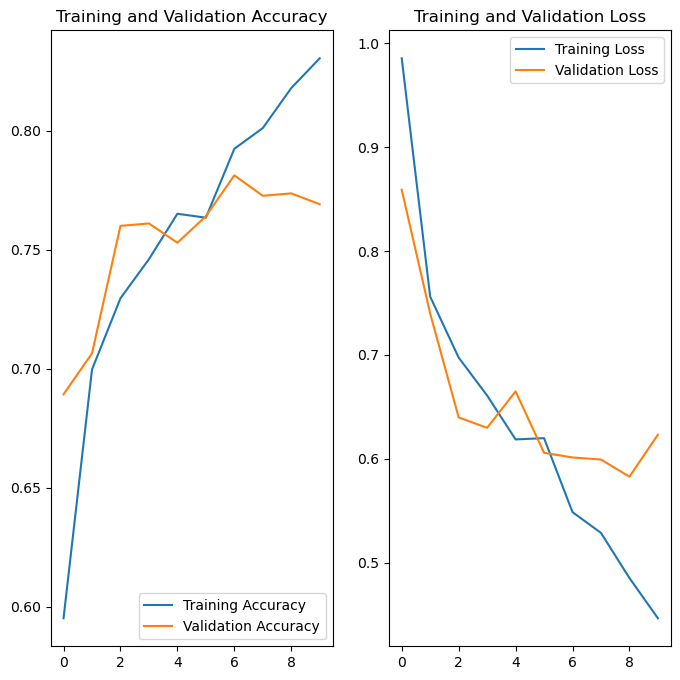

In [140]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()
